In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType
from torch.nn import Transformer

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
mm_scaler = MinMaxScaler()

class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 13:14].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()

        self.src_c = df.iloc[x_size:, 6:7].values #C
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()


        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])


        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

        self.src_v = src_v
        self.src_c = src_c
        self.trg = trg

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

In [3]:
# class StrideDataset_2(Dataset):
#     def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
#         df = pd.read_csv(file_path)
        
#         self.data = df.iloc[x_size:, 13:14].values #SoC
#         self.data = self.data.squeeze()

#         self.length = len(df) - x_size

#         num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
#         src = np.zeros([enc_seq_len, num_samples])
#         trg = np.zeros([target_seq_len, num_samples])


#         for i in np.arange(num_samples):
#             start_x = stride*i
#             end_x = start_x + enc_seq_len
#             src[:,i] = self.data[start_x:end_x]

#             start_y = stride*i + enc_seq_len
#             end_y = start_y + target_seq_len
#             trg[:,i] = self.data[start_y:end_y]

#         src = src.reshape(src.shape[0], src.shape[1], 1).transpose((1,0,2))
#         trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
#         self.src = src
#         self.trg = trg

#         self.len = len(src)

#     def __getitem__(self, i):
#         return self.src[i], self.trg[i, :-1], self.trg[i, 1:]
    
#     def __len__(self):
#         return self.len

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [5]:
train_dataset = StrideDataset("DST_80.csv", 200, 60, 1919, stride=30)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last=False)
dataset_d = CustomDataset("DST_80.csv", 1919)

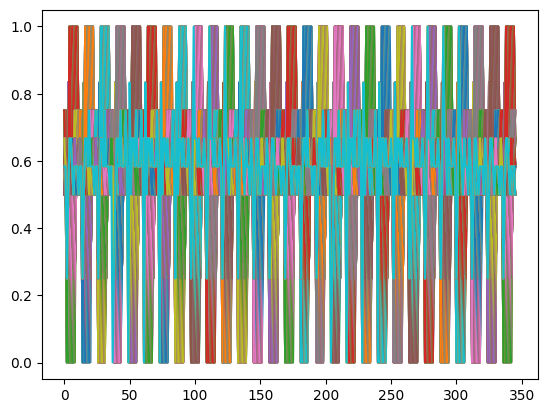

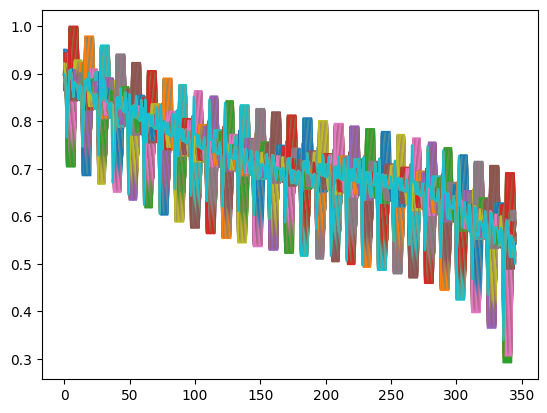

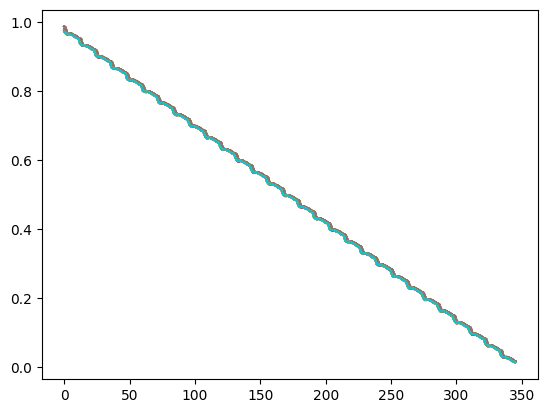

In [6]:
plt.plot(train_dataset.src_c.squeeze())
plt.show()
plt.plot(train_dataset.src_v.squeeze())
plt.show()
plt.plot(train_dataset.trg.squeeze())
plt.show()


In [7]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()

        # self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        
        # self.linear = nn.Linear(d_model, 1)
        # self.pos_encoder = PositionalEncoding(d_model, dropout)

        # self.encoder = nn.Linear(1, d_model)

        self.coder_in = nn.Linear(1,d_model)
        self.coder_pos = PositionalEncoding(d_model, dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)

        self.con_lin = nn.Linear(d_model*2, d_model)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=nlayers) #(target, memory) // memort->인코더에서 나온 컨텍스트벡터?
        self.linear = nn.Linear(d_model, 1)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    #def forward(self, src, tgt, srcmask, tgtmask):
    def forward(self, src_v, src_c, tgt_s, srcmask, tgtmask):
        src_v = self.coder_in(src_v)
        src_v = self.coder_pos(src_v)

        src_c = self.coder_in(src_c)
        src_c = self.coder_pos(src_c)

        con_v = self.transformer_encoder(src_v.transpose(0,1), srcmask).transpose(0,1)
        con_c = self.transformer_encoder(src_c.transpose(0,1), srcmask).transpose(0,1)
        
        #print(con_v.shape)
        #print(con_c.shape)
        

        con = torch.cat((con_v, con_c), dim=2)
        #print(con.shape)
        
        con = self.con_lin(con)
        #print(con.shape)
        
        
        #print(tgt_s.shape)
        tgt_s = self.coder_in(tgt_s)
        tgt_s = self.coder_pos(tgt_s)
        #print(tgt_s.shape)
        
        tgt = self.transformer_decoder(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        tgt = self.linear(tgt)

        return tgt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [8]:
lr = 0.000001
model = TFModel(500, 10, 256, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [9]:
epoch = 3000
model.train()
progress = tqdm(range(epoch))


for i in progress:
    batchloss = 0.0
    for (inputs_v, inputs_c, dec_inputs, outputs) in train_dataloader:
        optimizer.zero_grad()
        #print(inputs_v.shape[1])
        src_mask = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        #print(dec_inputs.shape[1])
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        result = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        
        #loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        loss = criterion(result, outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))




    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
        
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

loss: 0.001039: 100%|██████████| 3000/3000 [1:02:09<00:00,  1.24s/it]


In [10]:
eval_dataset = StrideDataset("US06_80.csv", 200, 60, 1207, stride=1)

eval_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=False, drop_last=False)

In [11]:
model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)



with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        output = output.permute(1,0,2)
        
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


print(predictions.shape)

torch.Size([10431])


In [12]:
predictions = predictions * 80

In [13]:
#predictions = mm_scaler.inverse_transform(predictions.reshape(-1,1))

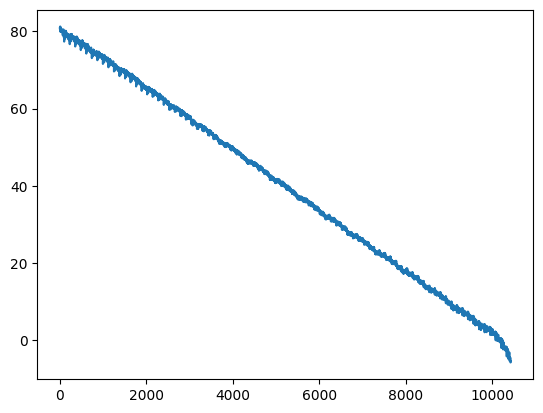

In [14]:
#plt.plot(range(20000-639,20000),dataset_d.y[20000-639:], label="real")
plt.plot(predictions, label="predict")
#plt.plot(dataset_d.y, label="real")
#plt.xlim(0,2)


# plt.legend()
# plt.show()

Text(0.5, 0, 'Time Steps')

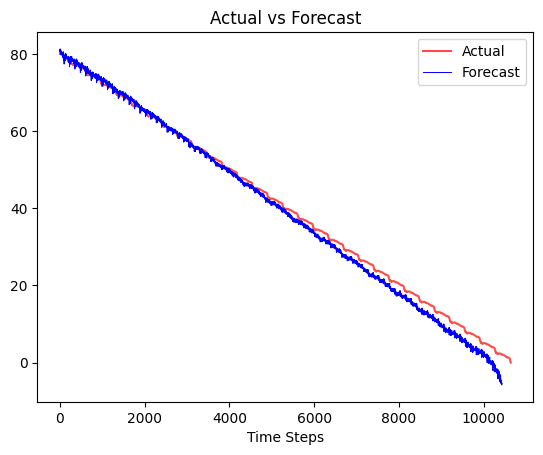

In [15]:
plt.plot(dataset_d.y, color='red', alpha=0.7)
plt.plot(predictions, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
#plt.xlim([4500,5000])A

In [16]:
from sklearn.metrics import mean_absolute_error 

print(dataset_d.y.shape)
print(predictions.shape)


mean_absolute_error(dataset_d.y[:10000], predictions[:10000])

(10639, 1)
torch.Size([10431])


1.466768848837608

train => 50 2 5 128  lr0.000001 epochs500



test  => 50 2 1 128 